# WM Segmentation using Voxel-wise Random Forest Classifier
In this project, I will use MRI T1-weighted data to perform white matter (WM) segmentation. Current trends for image segmentation utilize deep learning networks, specifically U-Net, which can be applied not only to WM/GM/CSF segmentation, but also segmentation of areas of pathology, such as cerebral infarcts / strokes or brain tumors. However, U-Net are large, require a lot of training data and take a long time to train on a GPU. An implementation of U-Net to perform white matter segmentation in shown in this [notebook](https://github.com/chauvu/chauvu.github.io/blob/main/Notebooks/wm_segmentation_unet.ipynb).

Therefore, in this work, I will explore the use of random forest classifier, applied on each voxel separately, to binary classify whether a voxel belongs to the white matter or not. The features that the classifier will learn include grey scale values of the current voxels as well as its 4 neighbors, and features extracted by compute vision filters from the *skimage* library. These features include:
* Sobel Filter
* Gaussian Filter
* Difference of Gaussians
* Sato Filter
* Local Binary Pattern

The disadvantage of this technique compared to deep learning methods is that U-Net take into account regional features near the voxel of interest as well as global features farther away from the voxel, whereas the random forest classifier will only have access to the features of the current voxel and greyscale values of its 4 immediate neighbors. Despite this weakness, I will demonstrate that the voxel-wise random forest classifier performs just as good as a typical U-Net.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from skimage.filters import sobel, gaussian, difference_of_gaussians, sato
from skimage.feature.texture import local_binary_pattern
from skimage import data, img_as_float
from sklearn.ensemble import RandomForestClassifier

We will train the classifier on different image patches, each of size 64x64.

In [2]:
np.random.seed(1)
patch_size = 64
root_dir = 'Brain_T1.nosync/'

This data has already been extracted previously. Unfortunately, due to HIPPA, this project cannot show images and provide data for the general audience.

In [3]:
with open(root_dir+'t1_patches_train2.npy', 'rb') as f:
	t1_patches_train = np.load(f)
with open(root_dir+'t1_patches_test2.npy', 'rb') as f:
	t1_patches_test = np.load(f)
with open(root_dir+'wm_patches_train2.npy', 'rb') as f:
	wm_patches_train = np.load(f)
with open(root_dir+'wm_patches_test2.npy', 'rb') as f:
	wm_patches_test = np.load(f)

len_train = len(t1_patches_train)
len_test = len(t1_patches_test)

### Test image: astronaut
Due to HIPPA, brain images cannot be shown in this script. There, I will be demonstrating the use of different filters using a default image `astronaut` Eileen Collins - the famous female NASA astronaut.

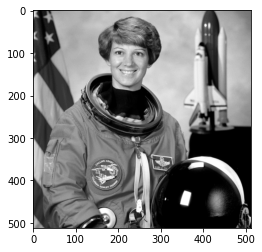

In [4]:
astronaut = img_as_float(data.astronaut())
astronaut = np.mean(astronaut, axis=2)

plt.imshow(astronaut, cmap='gray')

## Features Extraction
I will be creating 10 different features, including greyscale values from the voxel of interest and its 4 immediate neighbors, as well as features extracted from computer vision filters using the skimage library. The details of each features will be discussed more at length underneath.

In [5]:
labels_train = wm_patches_train.reshape(len_train*patch_size*patch_size)
labels_test = wm_patches_test.reshape(len_test*patch_size*patch_size)

### 1. Feature 1: Grey Level of Voxel

In [6]:
feature1_train_linear = t1_patches_train.reshape(len_train*patch_size*patch_size)
feature1_test_linear = t1_patches_test.reshape(len_test*patch_size*patch_size)

### 2-5. Features 2-5: Grey Levels of 4 Neighbor Voxels

In [7]:
feature2_train = np.empty(t1_patches_train.shape)
feature2_test = np.empty(t1_patches_test.shape)
feature3_train = np.empty(t1_patches_train.shape)
feature3_test = np.empty(t1_patches_test.shape)
feature4_train = np.empty(t1_patches_train.shape)
feature4_test = np.empty(t1_patches_test.shape)
feature5_train = np.empty(t1_patches_train.shape)
feature5_test = np.empty(t1_patches_test.shape)
for index in range(len_train):
	im = np.pad(t1_patches_train[index,:,:], 1)
	feature2_train[index,:,:] = im[1:-1,:-2]
	feature3_train[index,:,:] = im[1:-1,2:]
	feature4_train[index,:,:] = im[:-2,1:-1]
	feature5_train[index,:,:] = im[2:,1:-1]
for index in range(len_test):
	im = np.pad(t1_patches_test[index,:,:], 1)
	feature2_test[index,:,:] = im[1:-1,:-2]
	feature3_test[index,:,:] = im[1:-1,2:]
	feature4_test[index,:,:] = im[:-2,1:-1]
	feature5_test[index,:,:] = im[2:,1:-1]
feature2_train_linear = feature2_train.reshape(len_train*patch_size*patch_size)
feature2_test_linear = feature2_test.reshape(len_test*patch_size*patch_size)
feature3_train_linear = feature3_train.reshape(len_train*patch_size*patch_size)
feature3_test_linear = feature3_test.reshape(len_test*patch_size*patch_size)
feature4_train_linear = feature4_train.reshape(len_train*patch_size*patch_size)
feature4_test_linear = feature4_test.reshape(len_test*patch_size*patch_size)
feature5_train_linear = feature5_train.reshape(len_train*patch_size*patch_size)
feature5_test_linear = feature5_test.reshape(len_test*patch_size*patch_size)

### 6. Feature 6: Sobel Filter
The Sobel filter is very popular in the compution vision field for edge detection, as it creates an image that puts heavy emphasis on edges. A 2D Sobel filter comprises of the horizontal component (`sobel_h` in *skimage*) and vertical component (`sobel_v` in *skimage*). The 3x3 filters are shown below:
$$sobel_h = \begin{matrix} 1 & 2 & 1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{matrix}$$

and 

$$sobel_v = \begin{matrix} 1 & 0 & -1 \\ 2 & 0 & -2 \\ 1 & 0 & -1 \end{matrix}$$

The final filtered image is calculated as $sobel = \sqrt{sobel_h^2 + sobel_v^2}$. The astronaut image below shows the results from the Sobel filter, and we can clearly see that this filter is able to detect edges from the original image.

In [8]:
feature6_train = np.empty(t1_patches_train.shape)
feature6_test = np.empty(t1_patches_test.shape)
for index in range(len_train):
	feature6_train[index,:,:] = sobel(t1_patches_train[index,:,:])
for index in range(len_test):
	feature6_test[index,:,:] = sobel(t1_patches_test[index,:,:])
feature6_train_linear = feature6_train.reshape(len_train*patch_size*patch_size)
feature6_test_linear = feature6_test.reshape(len_test*patch_size*patch_size)

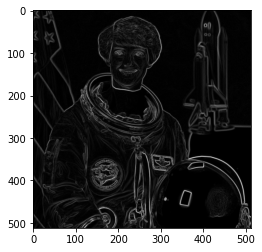

In [9]:
feature6_astronaut = sobel(astronaut)
plt.imshow(feature6_astronaut, cmap='gray')

### Feature 7: Gaussian Filter
The Gaussian filter is an extremely frequently used low-pass filter and is dependent on the parameter $\sigma$, which is the standard deviation of the Gaussian distribution. In this project, we choose $\sigma=5$ to remove the high-frequency components in our image, as demonstrated by the astronaut image.

In [10]:
feature7_train = np.empty(t1_patches_train.shape)
feature7_test = np.empty(t1_patches_test.shape)
for index in range(len_train):
	feature7_train[index,:,:] = gaussian(t1_patches_train[index,:,:], 5)
for index in range(len_test):
	feature7_test[index,:,:] = gaussian(t1_patches_test[index,:,:], 5)
feature7_train_linear = feature4_train.reshape(len_train*patch_size*patch_size)
feature7_test_linear = feature4_test.reshape(len_test*patch_size*patch_size)

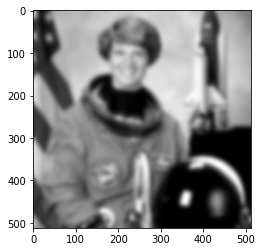

In [11]:
feature7_astronaut = gaussian(astronaut, 5)
plt.imshow(feature7_astronaut, cmap='gray')

### Feature 8: Difference of Gaussians Filter
As the original Gaussian filter is a low-pass filter, this Difference of Gaussians Filter is a band-pass filter as it removes both the low-frequency and high-frequency components of the image. We need to specify the high and low frequencies to remove, so `low_sigma` and `high_sigma` parameters need to be specified. Currently, we use $low \sigma=2$ and $high \sigma=1.6 \times high \sigma$. The output astronaut is shown below.

In [12]:
feature8_train = np.empty(t1_patches_train.shape)
feature8_test = np.empty(t1_patches_test.shape)
for index in range(len_train):
	feature8_train[index,:,:] = difference_of_gaussians(t1_patches_train[index,:,:], 2)
for index in range(len_test):
	feature8_test[index,:,:] = difference_of_gaussians(t1_patches_test[index,:,:], 2)
feature8_train_linear = feature8_train.reshape(len_train*patch_size*patch_size)
feature8_test_linear = feature8_test.reshape(len_test*patch_size*patch_size)

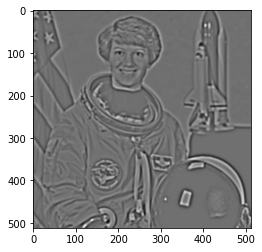

In [13]:
feature8_astronaut = difference_of_gaussians(astronaut, 2)
plt.imshow(feature8_astronaut, cmap='gray')

### Feature 9: Sato Filter
This is a special filter in computer vision, which detects continuous ridges and tubes in an image. In essence, it is quite similar to the Sobel edge detection filter, in what it emphasizes edges in an image. 

In [14]:
feature9_train = np.empty(t1_patches_train.shape)
feature9_test = np.empty(t1_patches_test.shape)
for index in range(len_train):
	feature9_train[index,:,:] = sato(t1_patches_train[index,:,:], mode='constant')
for index in range(len_test):
	feature9_test[index,:,:] = sato(t1_patches_test[index,:,:], mode='constant')
feature9_train_linear = feature9_train.reshape(len_train*patch_size*patch_size)
feature9_test_linear = feature9_test.reshape(len_test*patch_size*patch_size)

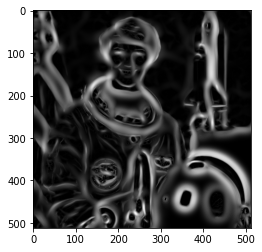

In [15]:
feature9_astronaut = sato(astronaut, mode='constant')
plt.imshow(feature9_astronaut, cmap='gray')

### Feature 10: Local Binary Pattern
This filter detects different textures on the image, instead of focusing on the frequency components or edges. As we can see from the filtered astronaut image, even the relatively *smoother* background has emphasis on the texture.

In [16]:
feature10_train = np.empty(t1_patches_train.shape)
feature10_test = np.empty(t1_patches_test.shape)
for index in range(len_train):
	feature10_train[index,:,:] = local_binary_pattern(t1_patches_train[index,:,:], 5, 5)
for index in range(len_test):
	feature10_test[index,:,:] = local_binary_pattern(t1_patches_test[index,:,:], 5, 5)
feature10_train_linear = feature10_train.reshape(len_train*patch_size*patch_size)
feature10_test_linear = feature10_test.reshape(len_test*patch_size*patch_size)

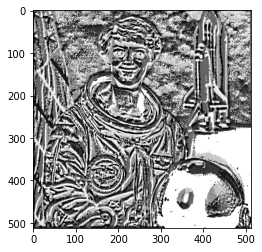

In [17]:
feature10_astronaut = local_binary_pattern(astronaut, 5, 5)
plt.imshow(feature10_astronaut, cmap='gray')

### Features -- Aggregation
I will aggregate all features into a matrix for random forest classifier.

In [18]:
features_train = np.concatenate((
					np.expand_dims(feature1_train_linear, axis=1), 
					np.expand_dims(feature2_train_linear, axis=1),
					np.expand_dims(feature3_train_linear, axis=1),
					np.expand_dims(feature4_train_linear, axis=1),
					np.expand_dims(feature5_train_linear, axis=1),
					np.expand_dims(feature6_train_linear, axis=1),
					np.expand_dims(feature7_train_linear, axis=1),
					np.expand_dims(feature8_train_linear, axis=1),
					np.expand_dims(feature9_train_linear, axis=1),
					np.expand_dims(feature10_train_linear, axis=1),
			), axis=1)

features_test = np.concatenate((
					np.expand_dims(feature1_test_linear, axis=1), 
					np.expand_dims(feature2_test_linear, axis=1),
					np.expand_dims(feature3_test_linear, axis=1),
					np.expand_dims(feature4_test_linear, axis=1),
					np.expand_dims(feature5_test_linear, axis=1),
					np.expand_dims(feature6_test_linear, axis=1),
					np.expand_dims(feature7_test_linear, axis=1),
					np.expand_dims(feature8_test_linear, axis=1),
					np.expand_dims(feature9_test_linear, axis=1),
					np.expand_dims(feature10_test_linear, axis=1),
			), axis=1)

## Random Forest Classifier

In [19]:
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=10, max_samples=0.05)
clf.fit(features_train, labels_train)
preds = clf.predict(features_test)
preds_reshape = preds.reshape(wm_patches_test.shape)

We can calculate the Dice Similarity Coefficient (DSC) for our segmentation. The mean DSC is 0.75, which is fairly low compared to DSC for white matter segmentation from regular U-Net networks (0.94 for a [U-Net](https://github.com/chauvu/chauvu.github.io/blob/main/Notebooks/wm_segmentation_unet.ipynb)). However, we need to realize that the training time and resources for a random forest classifier is much lower compared to training a neural network. Therefore, this simple binary classifier is preferable when resources are limited, such as no access to GPUs.

In [20]:
dsc = np.empty(len_test)
for index in range(len_test):
	label = wm_patches_test[index,:,:]
	pred = preds_reshape[index,:,:]
	tp = np.sum(label * pred)
	fp = np.sum((label==0) * pred)
	fn = np.sum(label * (pred==0))
	dsc[index] = (2*tp) / (2*tp + fp + fn)
print(np.mean(dsc))

0.754162133781493


We can also explore the how much each feature influences the classification, using the `feature_importances_` parameter of the random forest classifier. As we can see, features 1 (voxel's grayscale), 2 (voxel's neighbor), 8 (difference of gaussians) and 9 (sato filter) have the highest contributions to our classification. 

We notice that the left neighbor is most indicative of the classification results compared to other neighbors. This is misleading since it could indicate that the left voxels are more important. However, it is easily noticeable that the voxel of interest and its 4 neighbors' grayscale values all vary together and are not linearly independent. Therefore, even though each of the 4 voxels add some more information to the classification, the voxel's grayscale value is the most important feature.

Therefore, for better classification results, it is possible to perform dimensionality reduction, such as PCA or tSNE techniques to reduce interdependence between different features, which would reduce the variance of the random forest classifier.

In [21]:
feature_importances = clf.feature_importances_
for fi_index, fi in enumerate(feature_importances):
    print('Feature', fi_index+1, ':\t', round(fi,3))

Feature 1 :	 0.238
Feature 2 :	 0.111
Feature 3 :	 0.091
Feature 4 :	 0.038
Feature 5 :	 0.057
Feature 6 :	 0.091
Feature 7 :	 0.055
Feature 8 :	 0.189
Feature 9 :	 0.123
Feature 10 :	 0.008


# Conclusion
In this work, we perform white matter segmentation using voxel-wise random forest classifier. The input features are the voxel's and its neighbors' grayscale values as well as features extracted from computer vision filters with *skimage* library. The resulting Dice Similarity Coefficient is 0.75, which is very reasonable for this task.